In [1]:
from pynq_dpu import DpuOverlay
from dnndk import n2cube
overlay = DpuOverlay("./dpu.bit")

In [2]:
!dexplorer -m profile # run this to activate debug mode and dump traces

In [3]:
!dexplorer -w

[DPU IP Spec]
IP  Timestamp            : 2020-06-18 12:00:00
DPU Core Count           : 1

[DPU Core Configuration List]
DPU Core                 : #0
DPU Enabled              : Yes
DPU Arch                 : B1600
DPU Target Version       : v1.4.1
DPU Freqency             : 300 MHz
Ram Usage                : Low
DepthwiseConv            : Enabled
DepthwiseConv+Relu6      : Enabled
Conv+Leakyrelu           : Enabled
Conv+Relu6               : Enabled
Channel Augmentation     : Disabled
Average Pool             : Enabled



In [4]:
overlay.load_model("./dpu_Unet.elf")

In [5]:
KERNEL_NAME = "Unet"
KERNEL_CONV_INPUT = "block1_conv1_convolution"
KERNEL_OUTPUT = "conv2d_13_convolution"

In [6]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_NAME)
task = n2cube.dpuCreateTask(kernel, 0)

In [7]:
input_len = n2cube.dpuGetInputTensorSize(task, KERNEL_CONV_INPUT)
output_len = n2cube.dpuGetOutputTensorSize(task, KERNEL_OUTPUT)
conf = n2cube.dpuGetOutputTensorAddress(task, KERNEL_OUTPUT)
output_scale = n2cube.dpuGetOutputTensorScale(task, KERNEL_OUTPUT)
print(input_len, output_len, conf, output_scale)

393216 524288 <dnndk.n2cube.LP_c_byte object at 0x7f7cf047b8> 0.0625


In [8]:
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import cv2

In [9]:
def result_map_to_img(res_map, img):
    #img = np.zeros((256, 512, 3), dtype=np.uint8)
    res = np.squeeze(res_map)
  
    argmax_idx = np.argmax(res, axis=2)
  
    # For np.where calculation.
    person = (argmax_idx == 1)
    car = (argmax_idx == 2)
    road = (argmax_idx == 3)
  
    img[:, :, 0] = np.where(person, 255, 0)
    img[:, :, 1] = np.where(car, 255, 0)
    img[:, :, 2] = np.where(road, 255, 0)
  

In [10]:
calib_img_path = "./leftImg8bit/test/" #"./person/person/"    
calib_batch_size = 5
start_iter = 135
## images for evaluation
paths = []
for (path, dirname, files) in sorted(os.walk(calib_img_path)):
    for filename in sorted(files):
        if filename.endswith(('.jpg', '.png')):
            paths.append(os.path.join(path, filename))
images = np.zeros((calib_batch_size, 256, 512, 3))
images_scaled = []
for index in range(0, calib_batch_size):
    #print("Path: " + paths[(iter * calib_batch_size + index) % len(paths)])
    img_raw = cv2.imread(paths[(start_iter * calib_batch_size + index*35) % len(paths)], 1)
    try:
        img_scaled = cv2.resize(img_raw,(512, 256))
        images_scaled.append(img_scaled)
        img = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 127.5 - 1
        images[index] = img.astype(np.float32)
    except cv2.error as e:
            print('Invalid frame!')
            print(e)

In [11]:
start = time()
result = np.zeros((calib_batch_size, 256, 512, 3), dtype=np.uint8)
classes = np.zeros((256, 512, 4), dtype=np.int8)
for i in range(calib_batch_size):
    image_data = np.expand_dims(images[i].astype(np.float32), 0)
    n2cube.dpuSetInputTensorInHWCFP32(task, KERNEL_CONV_INPUT, image_data, input_len)
    n2cube.dpuRunTask(task)
    image_out = n2cube.dpuGetOutputTensorInHWCFP32(task, KERNEL_OUTPUT, output_len)
    classes = np.array(image_out, dtype=np.int8)
    classes = np.reshape(classes, (1, 256, 512, 4))
    result_map_to_img(classes, result[i])
stop = time()
throughput = calib_batch_size / (stop - start)
print("Throughput in FPS: ", throughput)

Throughput in FPS:  0.9135413431351495


In [12]:
results_combined = np.zeros((calib_batch_size, 256, 2*512, 3), dtype=np.uint8)
for i in range(calib_batch_size):
    results_combined[i] = np.concatenate((images_scaled[i], result[i]), axis=1)

In [13]:
batch_results_combined = results_combined[0]
for i in range(1, calib_batch_size, 1):
    batch_results_combined = np.concatenate((batch_results_combined, results_combined[i]), axis=0)
    

True

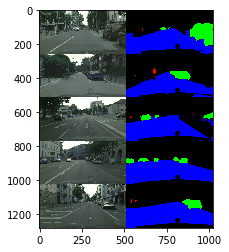

In [14]:
plt.imshow(batch_results_combined)
cv2.imwrite("./batch_results.png", batch_results_combined)

In [15]:
n2cube.dpuDestroyTask(task)
n2cube.dpuDestroyKernel(kernel)

0